# Import Libraries

In [ ]:
from fastai import *
from fastai.vision import *

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Define Datapath

In [ ]:
path = '/content/drive/My Drive/Multi_Label_dataset'

Read and view csv file with pandas

In [5]:
df = pd.read_csv(path+'/train.csv')
df.head()

,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,N/A,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,tt0086425,"['Comedy', 'Drama']",0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,tt0085549,"['Drama', 'Romance', 'Music']",0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,tt0086465,['Comedy'],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,tt0086567,"['Sci-Fi', 'Thriller']",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,tt0086034,"['Action', 'Adventure', 'Thriller']",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


# Data Augmentation

In [ ]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [ ]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train.csv', folder='Images', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [ ]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

 View some Images

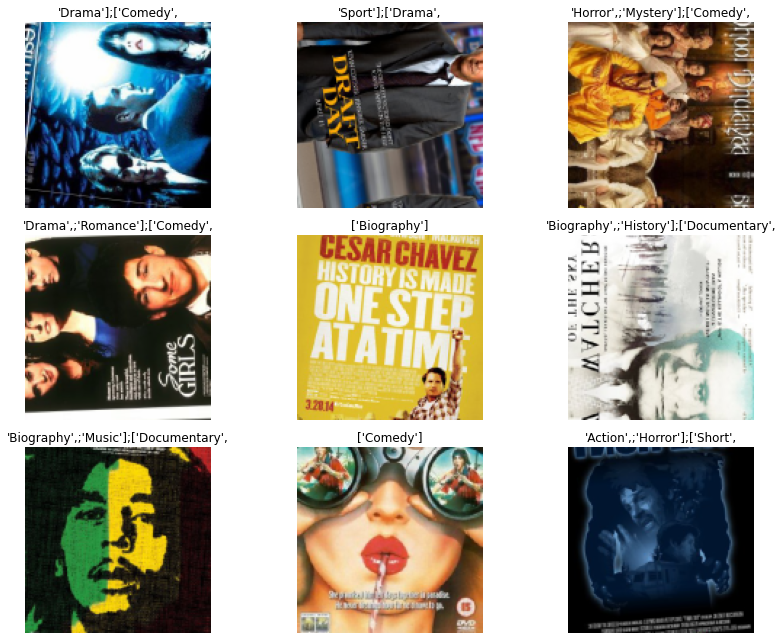

In [ ]:
data.show_batch(rows=3, figsize=(12,9))

# Download and Train Model

In [ ]:
learn = cnn_learner(data, models.resnet50)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.905374,#na#,31:16


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


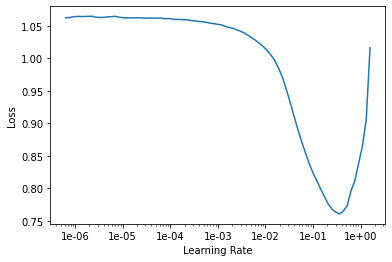

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 0.01

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.474060,0.111532,09:28
1,0.156942,0.097926,01:24
2,0.108704,0.094504,01:26
3,0.096302,0.092124,01:26
4,0.091410,0.091191,01:25


In [ ]:
learn.save('stage-1-rn50')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


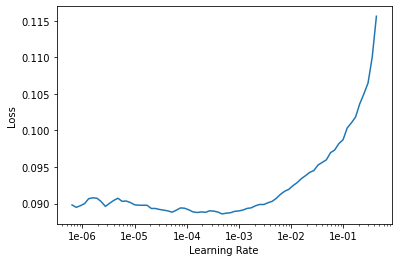

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-3, lr/5))

epoch,train_loss,valid_loss,time
0,0.092081,0.100714,01:27
1,0.095624,0.285824,01:27
2,0.095105,0.093310,01:28
3,0.092865,0.091699,01:28
4,0.090497,0.091394,01:28


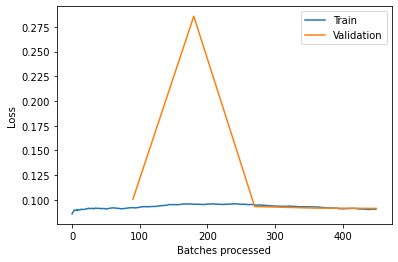

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-rn50')

In [ ]:
learn.export()

In [ ]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [ ]:
learn.freeze()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


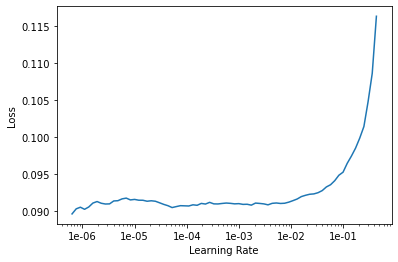

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.092682,0.093154,02:07
1,0.094544,0.093898,02:04
2,0.092010,0.091876,02:05
3,0.089504,0.093525,02:08
4,0.087831,0.091267,02:06


In [ ]:
learn.save('stage-1-256-rn50')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,time
0,0.087475,0.092050,02:43
1,0.087753,0.091253,02:41
2,0.087056,0.090035,02:40
3,0.085925,0.089328,02:41
4,0.085259,0.089684,02:40


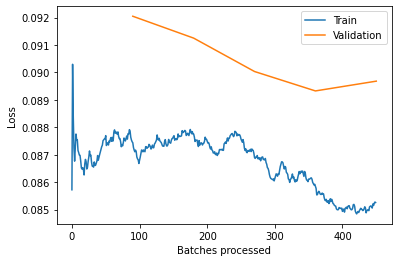

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('final_path')

In [ ]:
learn.export()

# Use trained model to classify a Single Image

In [ ]:
img_path = '/content/drive/My Drive/test_img.jpg'

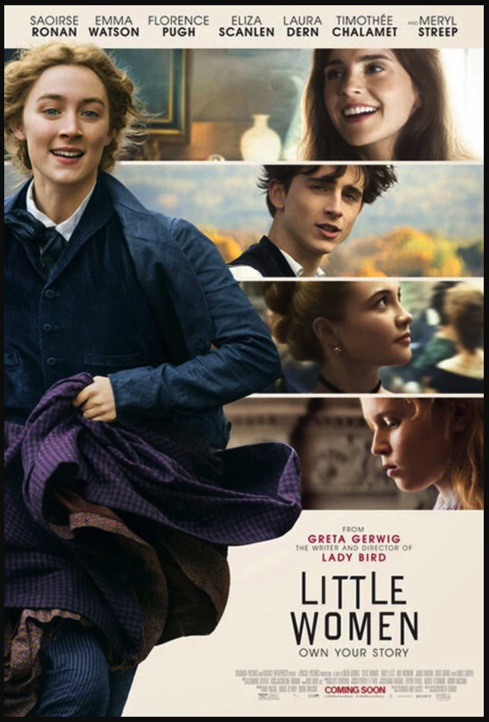

In [7]:
from PIL import Image
trn_tfms, val_tfms = get_transforms(models.resnet50, 256)
im = (open_image(img_path))
im


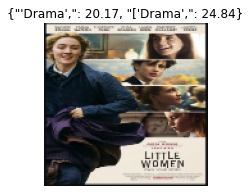

In [10]:
import os
plt.rcParams.update({'figure.max_open_warning': 0}) # avoid matplotlib warnings
learner = load_learner('/content/drive/My Drive/Multi_Label_dataset/models/stage-2-rn50.pth','/content/drive/My Drive/Multi_Label_dataset/export.pkl') # load our pre-trained model we just exported

img = open_image(img_path)
img = img.apply_tfms(tfms=get_transforms()[1], size=128, resize_method=3) # resize the images the same way a the pre-processing
preds, idx, output = learner.predict(img) # get predictions for each class and show only the one > to our threshold
d = dict({learner.data.classes[i]: round(to_np(p)*100,2) for i, p in enumerate(output) if p > 0.2})
img.show(title=str(d))